### Quantstats

이번 시간에서는 전략의 백테스팅을 위한 파이썬 라이브러리인 `Quantstats`의 사용법을 간단히 살펴보는 것으로 한다.

In [1]:
import quantstats as qs

#### Markowitz Portfolio Optimization

- 1953년 Harry Markowitz가 개발한 현대적 자산 배분 방법이다.
- 위험을 최소화하고, Sharpe Ratio가 극대화되는 지점에서 배분 비율을 결정한다.

In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
import pandas_datareader.data as web

data = pd.DataFrame()
for code in ['005930', '000660', '005380', '035420'] : 
    data = pd.concat([data,web.DataReader(code, 'naver', start = '2015-01-01', end = '2024-02-24')['Close'].astype(float)], axis=1)

data.columns = ['samsung', 'hynics', 'hyundai_motor', 'naver']
# 5개의 종목을 선정하는 경우
noa = len(data.columns) # noa : Number of Asset, 종목의 개수
data.index = pd.to_datetime(data.index)

In [3]:
data.head()

,samsung,hynics,hyundai_motor,naver
2015-01-02,26600.0,47750.0,169000.0,146407.0
2015-01-05,26660.0,47650.0,168000.0,150012.0
2015-01-06,25900.0,47500.0,164500.0,148811.0
2015-01-07,26140.0,47400.0,170000.0,146607.0
2015-01-08,26280.0,49950.0,178000.0,149011.0


배분 비율을 추정하는 train data와 전략의 성과를 추정하는 test data를 분리한다

In [4]:
data_test = data['2020':]
data_train = data[:'2019']

**Montecarlo Simulation**

최적 배분 비율 추정을 위해 몬테카를로 시뮬레이션을 수행한다.

In [5]:
weights = np.random.random(noa)
weights /= sum(weights)

# get returns
ret = data_train.pct_change().dropna()
train_days = len(data_train)

# use sample mean and variance as estimates of expected portfolio return and variance
port_mean = np.sum(weights * ret.mean() * train_days) # sample mean
# 곱해주는 수는 data의 row의 길이이다
port_var = np.dot(weights.T, np.dot(ret.cov() * train_days, weights)) #sample variance
port_std = np.sqrt(port_var) # sample standard deviation

초기의 가중치를 랜덤하게 지정해 준 다음, return을 계산하여 전체 포트폴리오의 수익률 평균과 리스크를 계산해 주는 과정을 거친다

In [6]:
port_rets = []
port_std = []
all_weights = []

def ret_std(weight, ret):
    port_mean = np.sum(weight * ret.mean() * 1026)
    port_var = np.dot(weight.T, np.dot(ret.cov() * 1026, weight))
    port_std = np.sqrt(port_var)
    return port_mean, port_std

for w in range(5000):
    weight = np.random.random(noa)
    weight /= np.sum(weight)
    all_weights.append(weight)  # 가중치 저장
    mu, sig = ret_std(weight, ret)
    port_rets.append(mu)
    port_std.append(sig)

sharpe_ratio = np.array(port_rets) / np.array(port_std)
# sharpe ratio

mean variance 평면에 가능한 포트폴리오의 경우들을 전부 뽑기 위해서 우선 포트폴리오의 mean과 standard deviation(risk)를 계산해 주는 함수를 임의로 지정한다.

5000번의 몬테카를로 시뮬레이션을 돌렸을 때의 결과를 생성하여 평균과 risk에 대한 정보를 리스트에 stack해 준다

In [7]:
# 최대 Sharpe Ratio 찾기
max_sharpe_idx = np.argmax(sharpe_ratio)
max_sharpe_return = port_rets[max_sharpe_idx]
max_sharpe_std = port_std[max_sharpe_idx]

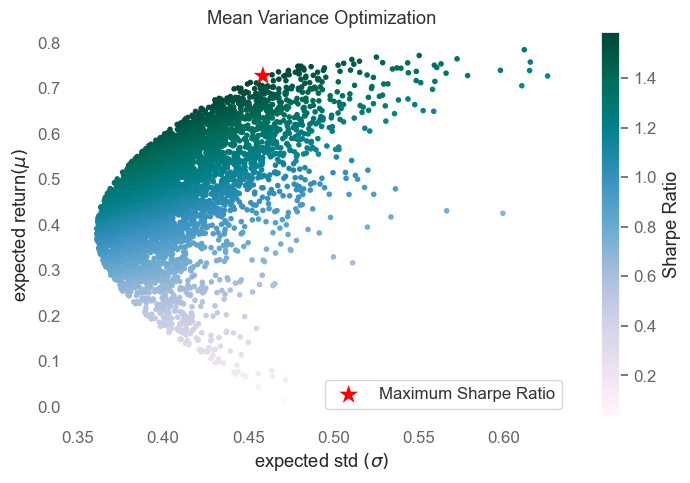

In [8]:
plt.figure(figsize = (8,5))
plt.scatter(port_std, port_rets, c = sharpe_ratio, marker = '.',  cmap='PuBuGn')
plt.colorbar(label='Sharpe Ratio')
plt.scatter(
    max_sharpe_std, max_sharpe_return, 
    c = 'red', s = 200, edgecolors = 'none', label = 'Maximum Sharpe Ratio', marker = '*'
)
plt.legend(labelspacing=0.8)
plt.ylabel('expected return$(μ)$')
plt.xlabel('expected std $(σ)$')
plt.title('Mean Variance Optimization')
plt.grid()

In [9]:
max_sharpe_idx = np.argmax(sharpe_ratio)
optimal_weights = all_weights[max_sharpe_idx]

train data를 이용해 추정한 최적의 배분 비율을 다음과 같이 구할 수 있다

In [10]:
optimal_weights

array([0.67751441, 0.20954012, 0.00100788, 0.11193759])

optimal weights를 test data를 이용해 성과를 추정해 볼 수 있다

In [11]:
weighted_portfolio = np.log(data_test / data_test.shift(1)).dropna() * optimal_weights
equal_weighted_portfolio = np.log(data_test / data_test.shift(1)).dropna() * (1 / 5)

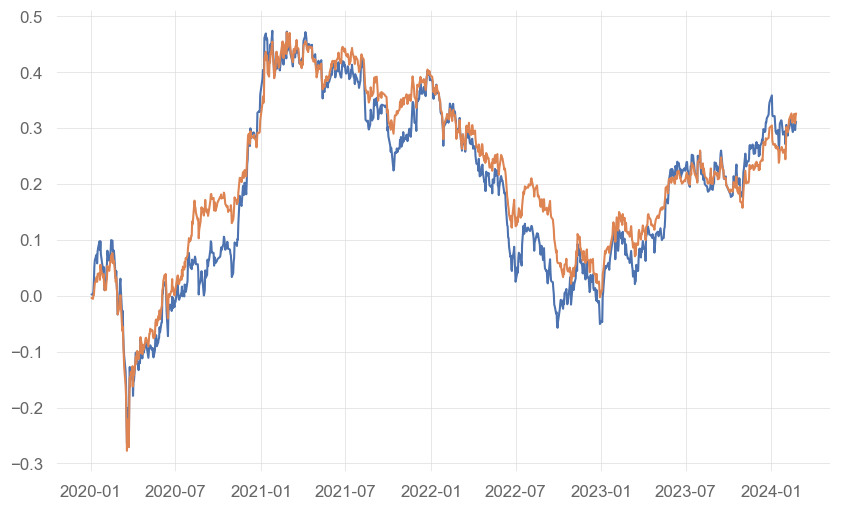

In [12]:
plt.plot(
    weighted_portfolio.sum(axis = 1).cumsum()
)
plt.plot(
    equal_weighted_portfolio.sum(axis = 1).cumsum()
)

#### Quantstats
- quantstats 라이브러리를 사용하여 다음과 같이 사용 가능하다.
- 월별 수익률을 다음과 같이 heatmap으로 표현할 수 있다.

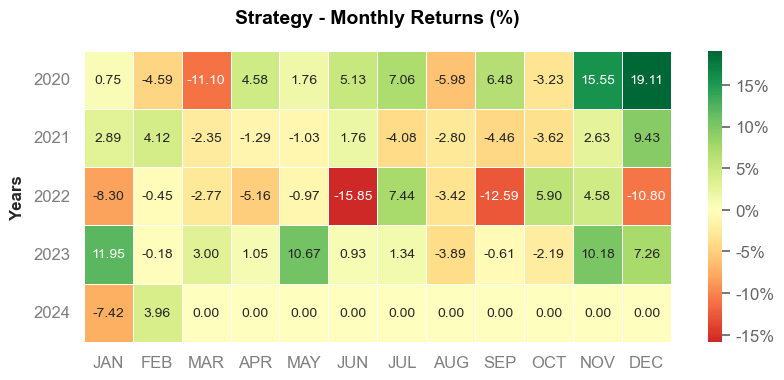

In [13]:
qs.plots.monthly_returns(weighted_portfolio.sum(axis = 1), figsize = (8, 4))

누적 수익률은 다음과 같이 구할 수 있다.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


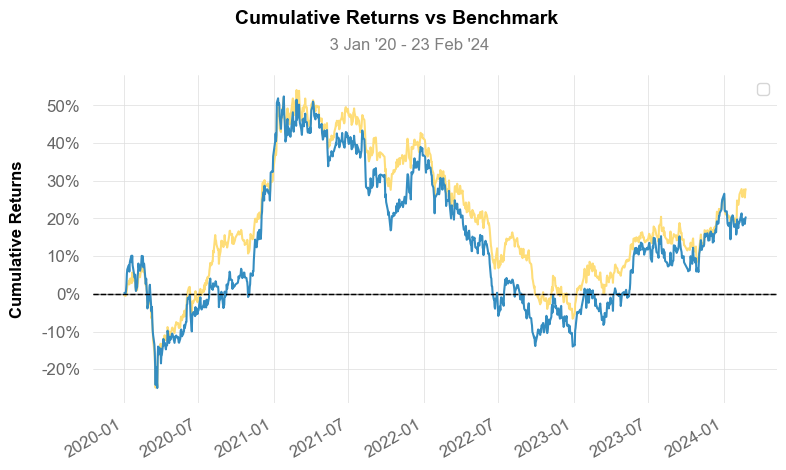

In [16]:
qs.plots.returns(
    returns = weighted_portfolio.sum(axis = 1),
    benchmark = equal_weighted_portfolio.sum(axis = 1),
    figsize = (8, 5)
)

변동성 매칭 수익률을 다음과 같이 표현할 수 있다.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


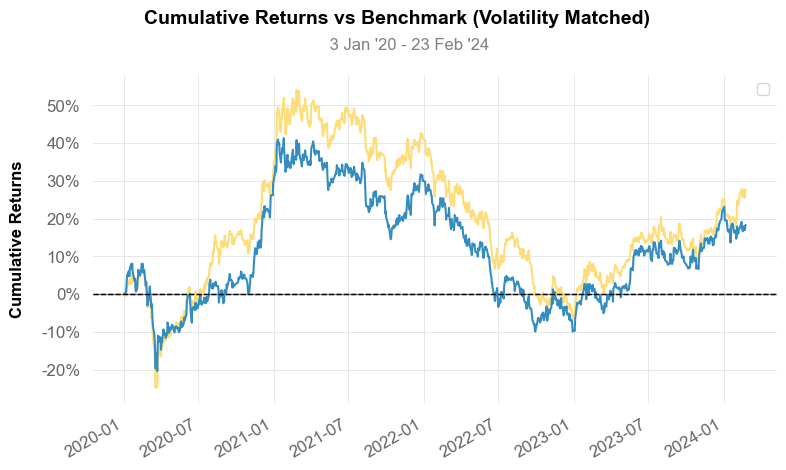

In [23]:
qs.plots.returns(
    returns = weighted_portfolio.sum(axis = 1),
    benchmark = equal_weighted_portfolio.sum(axis = 1),
    figsize = (8, 5),
    match_volatility = True
)

주요 성과지표는 다음과 같이 지정할 수 있다.

In [18]:
qs.reports.metrics(
    weighted_portfolio.sum(axis = 1),
    benchmark = equal_weighted_portfolio.sum(axis = 1)
)

                    Benchmark    Strategy
------------------  -----------  ----------
Start Period        2020-01-03   2020-01-03
End Period          2024-02-23   2024-02-23
Risk-Free Rate      0.0%         0.0%
Time in Market      100.0%       100.0%

Cumulative Return   27.76%       20.31%
CAGR﹪              4.17%        3.13%

Sharpe              0.4          0.31
Prob. Sharpe Ratio  79.12%       73.23%
Sortino             0.6          0.46
Sortino/√2          0.42         0.32
Omega               1.05         1.05

Max Drawdown        -39.38%      -43.56%
Longest DD Days     1093         1124

Gain/Pain Ratio     0.07         0.05
Gain/Pain (1M)      0.33         0.26

Payoff Ratio        1.1          1.09
Profit Factor       1.07         1.05
Common Sense Ratio  1.17         1.2
CPC Index           0.59         0.56
Tail Ratio          1.09         1.14
Outlier Win Ratio   3.95         3.15
Outlier Loss Ratio  3.63         2.96

MTD                 8.38%        3.96%
3M           

포트폴리오의 성과 지표인 sharpe ratio의 이동평군 값을 다음과 같이 쉽게 확인할 수 있다.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


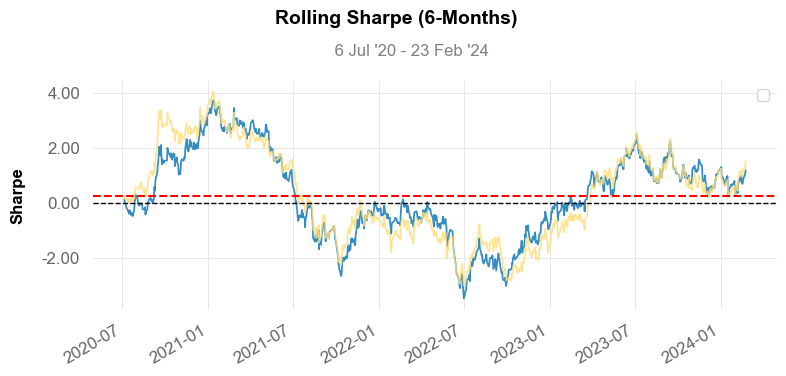

In [20]:
qs.plots.rolling_sharpe(
    weighted_portfolio.sum(axis = 1),
    benchmark = equal_weighted_portfolio.sum(axis = 1),
    figsize = (8, 4)
)

전략의 베타를 다음과 같이 표현할 수 있다.

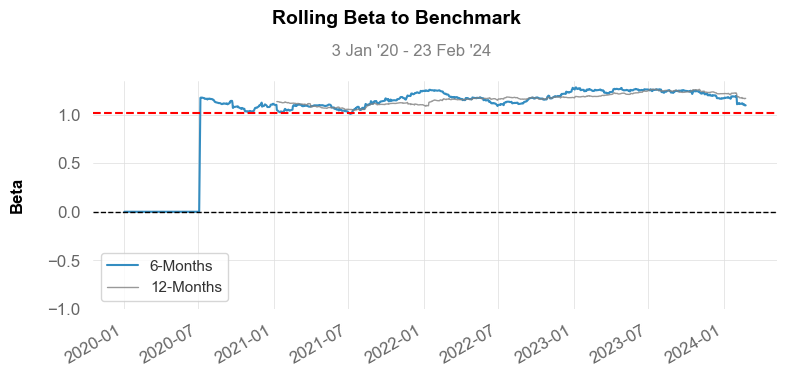

In [21]:
qs.plots.rolling_beta(
    weighted_portfolio.sum(axis = 1),
    benchmark = equal_weighted_portfolio.sum(axis = 1),
    figsize = (8, 4)
)

전체 성과 지표에 대한 report를 받아 보려면 다음과 같은 방법을 사용하면 된다.

/Users/junghunlee/anaconda3/envs/FinancialMachineLearning/lib/python3.10/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/Users/junghunlee/anaconda3/envs/FinancialMachineLearning/lib/python3.10/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/Users/junghunlee/anaconda3/envs/FinancialMachineLearning/lib/python3.10/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over bot

                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2020-01-03   2020-01-03
End Period                 2024-02-23   2024-02-23
Risk-Free Rate             0.0%         0.0%
Time in Market             100.0%       100.0%

Cumulative Return          27.76%       20.31%
CAGR﹪                     4.17%        3.13%

Sharpe                     0.4          0.31
Prob. Sharpe Ratio         79.12%       73.23%
Smart Sharpe               0.39         0.3
Sortino                    0.6          0.46
Smart Sortino              0.58         0.44
Sortino/√2                 0.42         0.32
Smart Sortino/√2           0.41         0.31
Omega                      1.05         1.05

Max Drawdown               -39.38%      -43.56%
Longest DD Days            1093         1124
Volatility (ann.)          20.06%       25.03%
R^2                        0.85         0.85
Information Ratio          -0.0         -0.0
Calmar              

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2021-01-26,2022-12-29,2024-02-23,1124,-43.561847,-41.850379
2,2020-01-23,2020-03-23,2020-11-13,296,-31.887312,-26.858890
3,2021-01-12,2021-01-18,2021-01-22,11,-5.330255,-3.493377
4,2020-12-10,2020-12-22,2020-12-23,14,-3.062935,-1.789734
5,2020-11-30,2020-11-30,2020-12-01,2,-2.062891,-0.042949


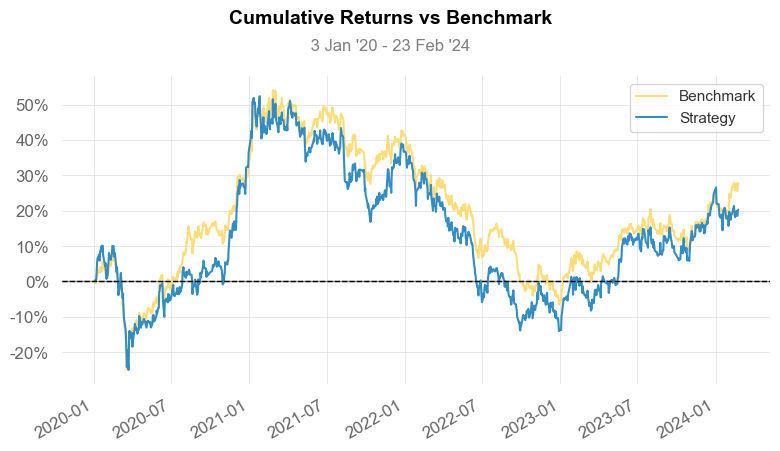

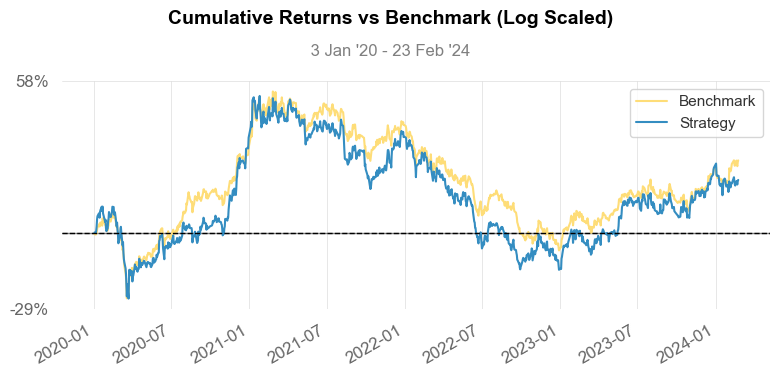

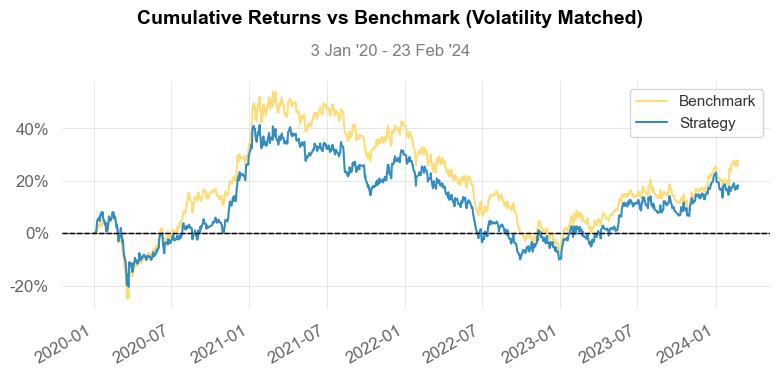

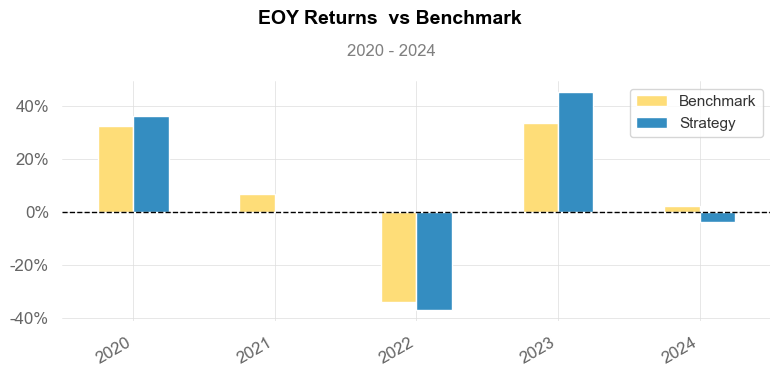

/Users/junghunlee/anaconda3/envs/FinancialMachineLearning/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


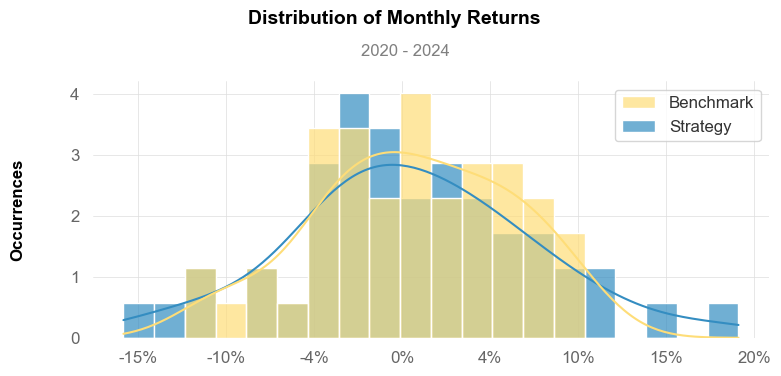

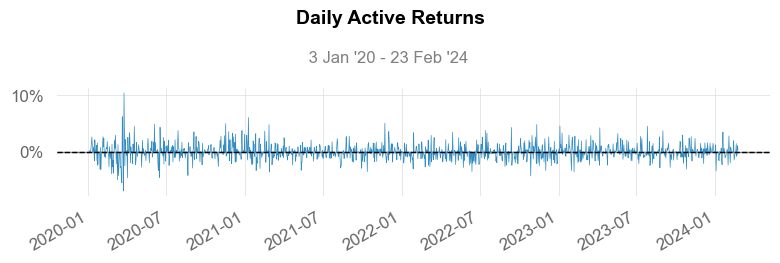

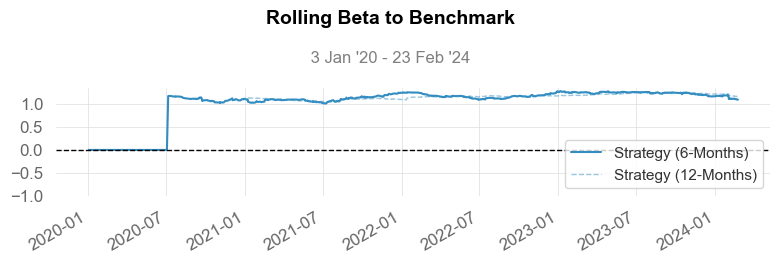

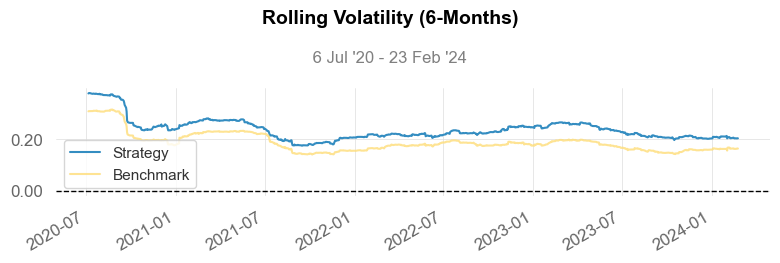

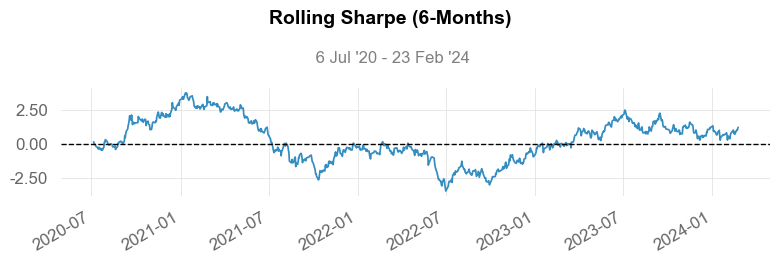

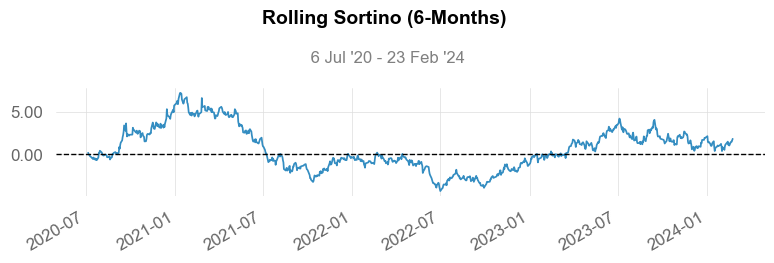

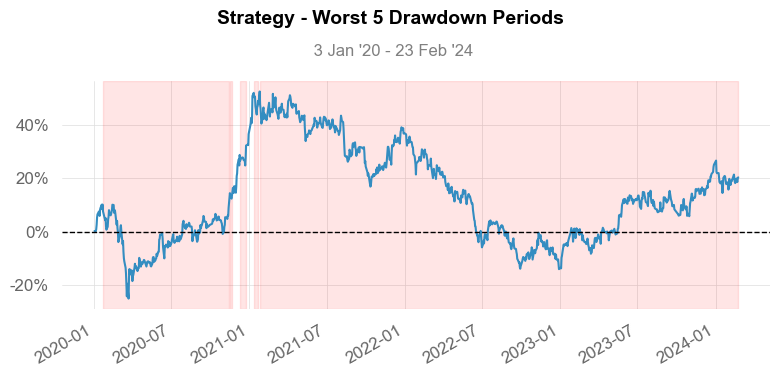

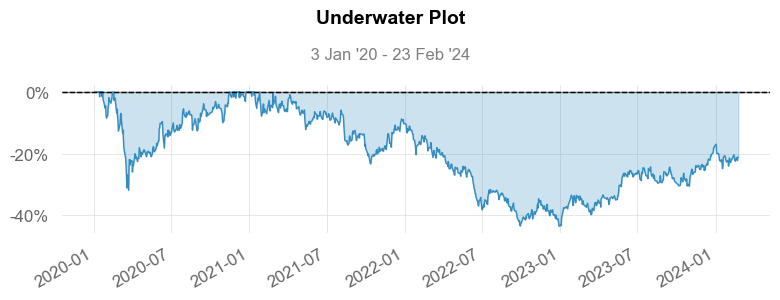

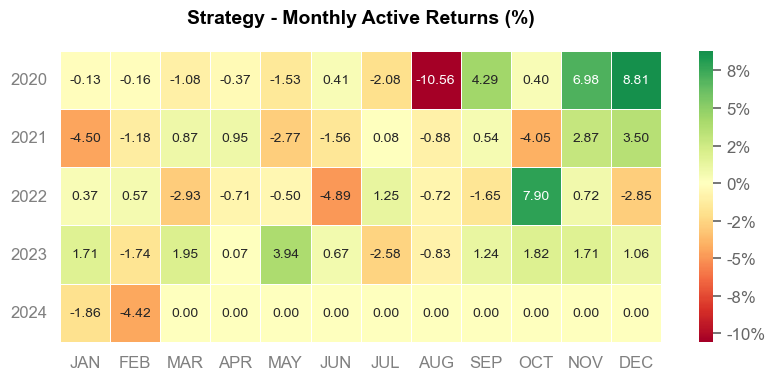

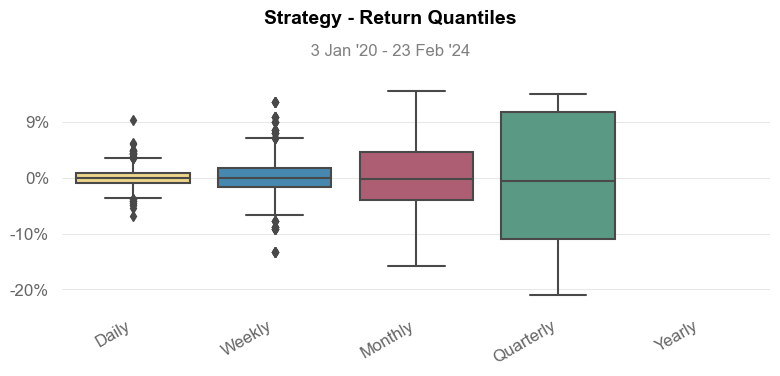

In [22]:
qs.reports.full(
    weighted_portfolio.sum(axis = 1),
    benchmark = equal_weighted_portfolio.sum(axis = 1),
)